# Persoalan 3
Carilah data medis lalu lakukan data mining classification dengan metode DT untuk pasien apakah normal (tidak sakit) atau dinyatakan sakit. Kemudian hitunglah performanya

## Package

In [303]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

## Input Data

In [304]:
df = pd.read_csv('../dataset/diabetes.csv')

## Eploratory Data Analysis

In [305]:
df['Outcome'] = df['Outcome'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB


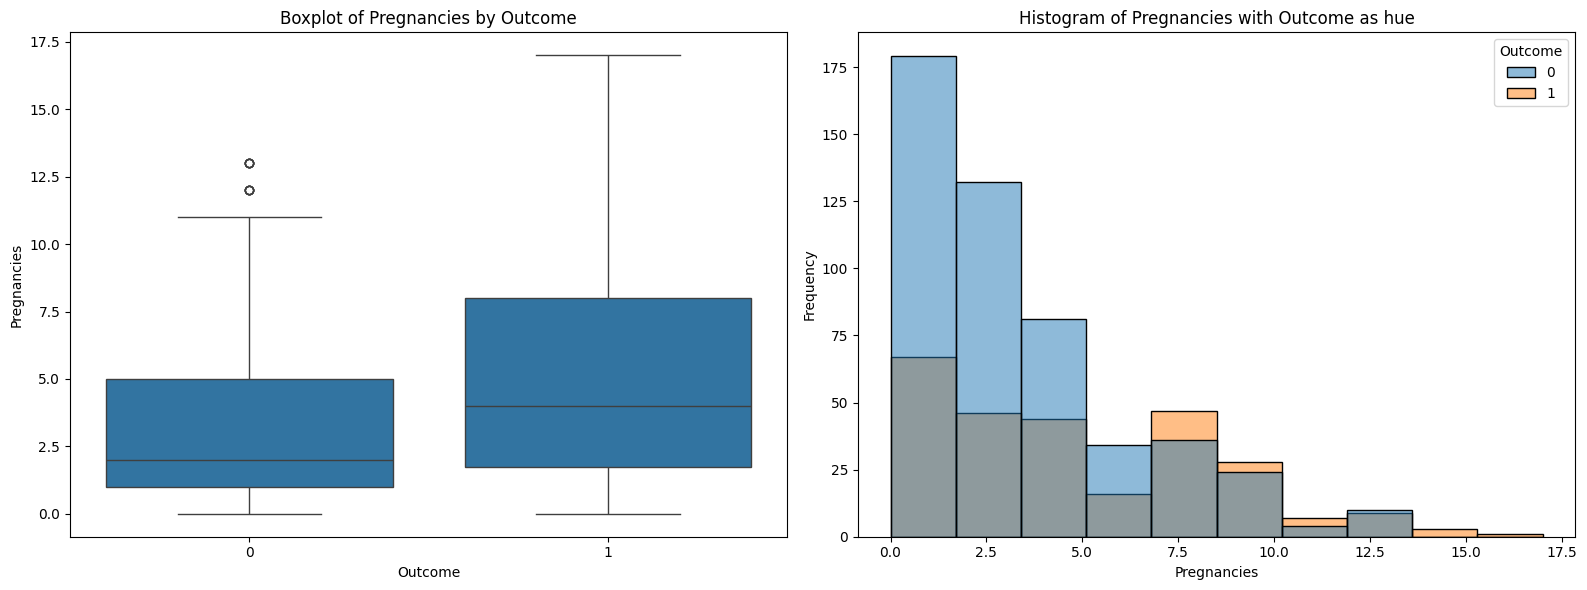

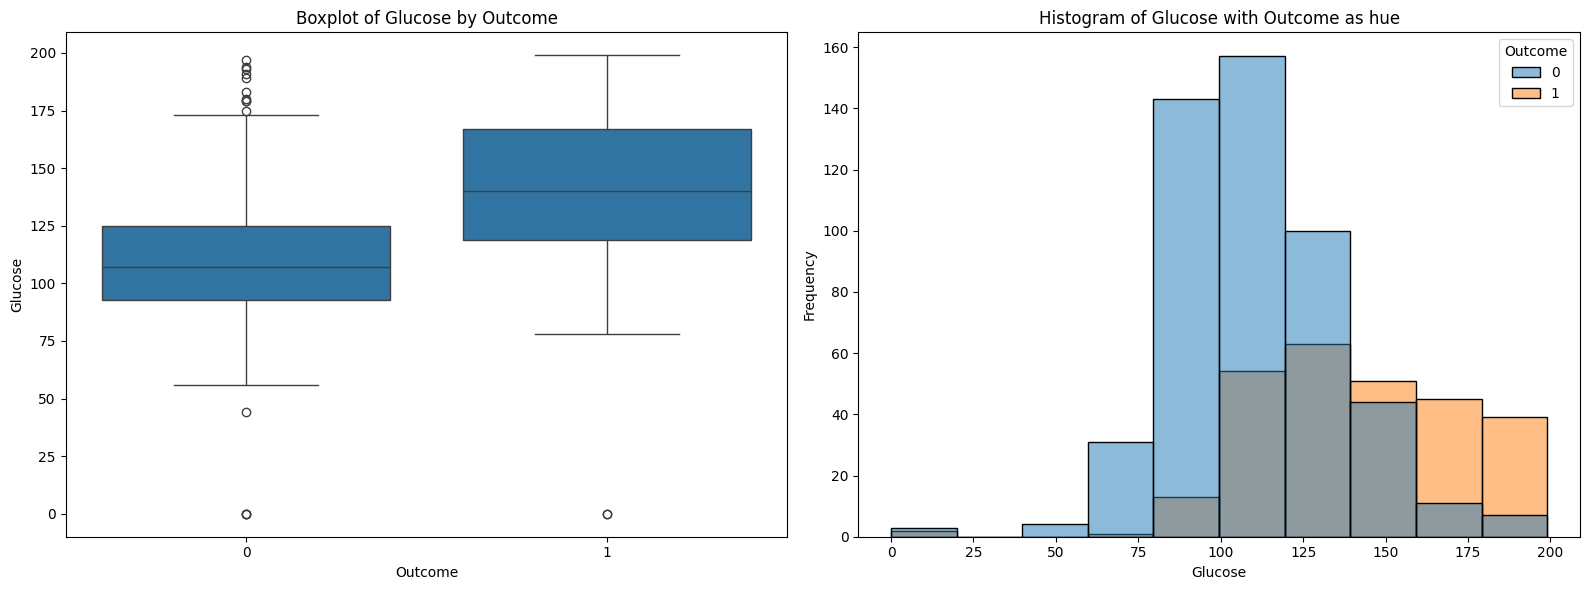

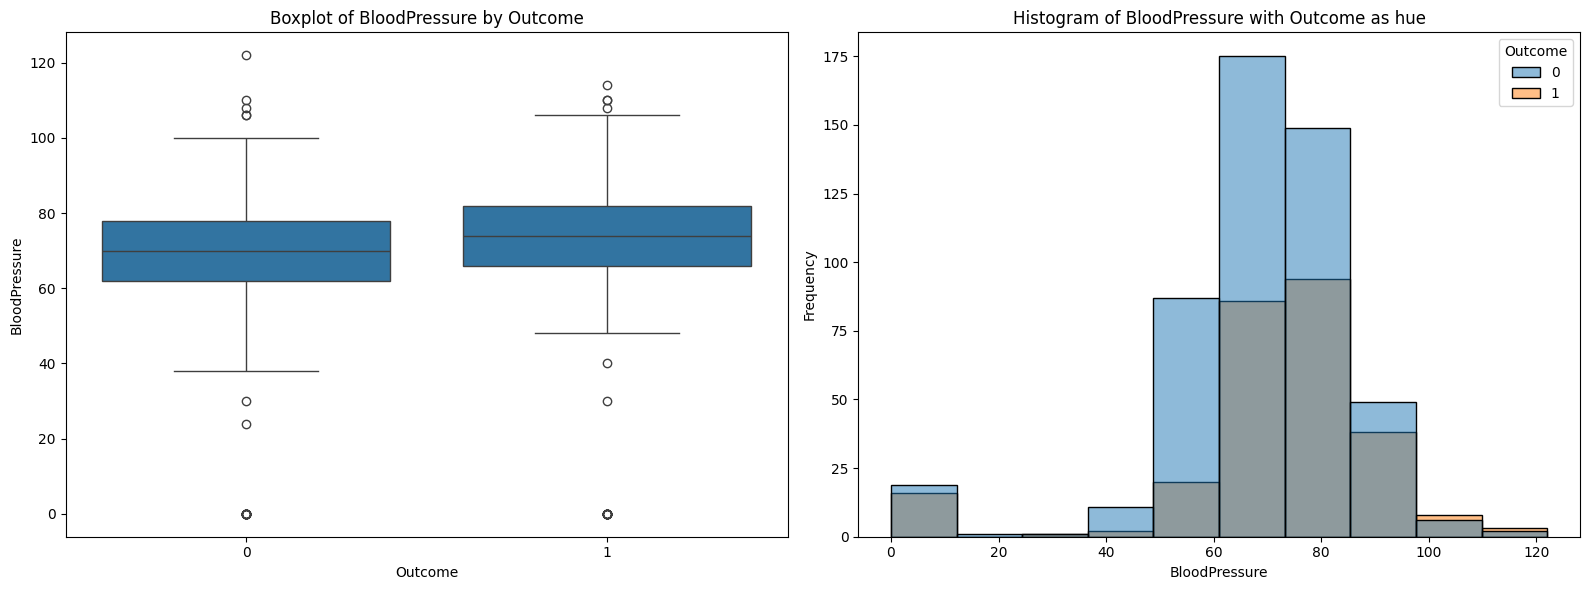

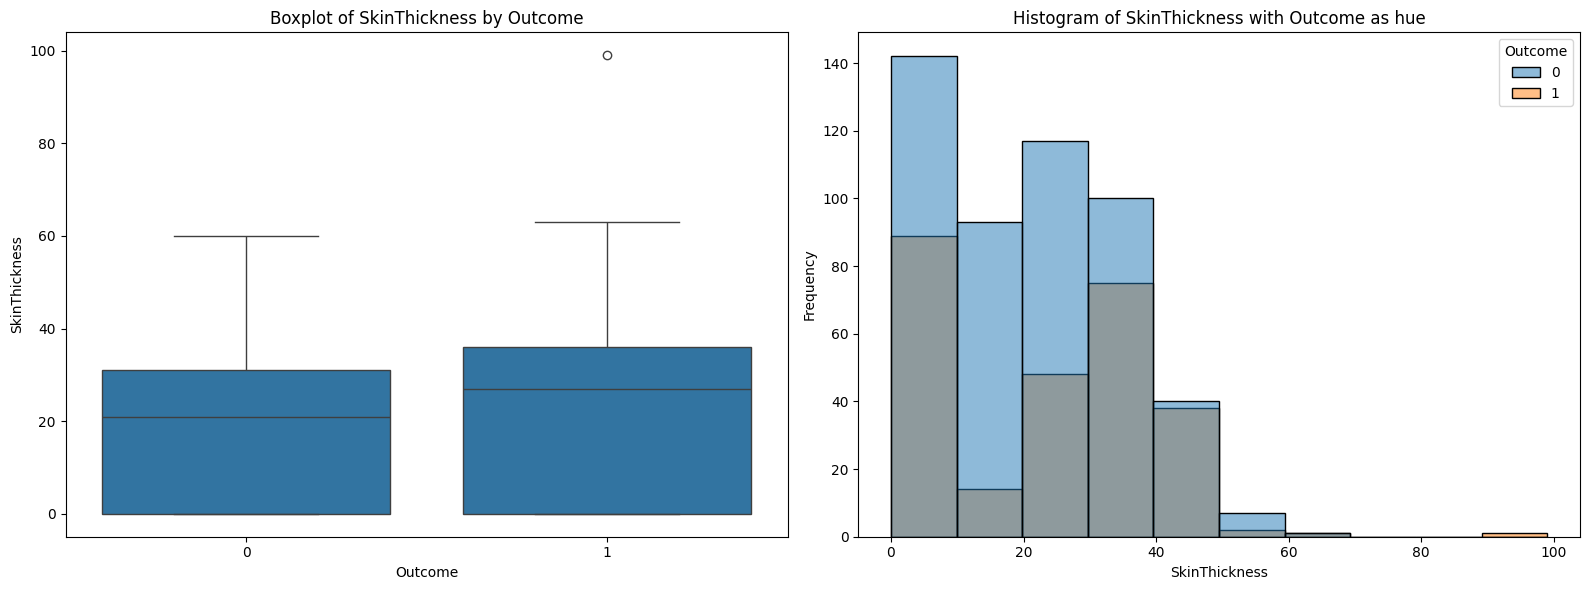

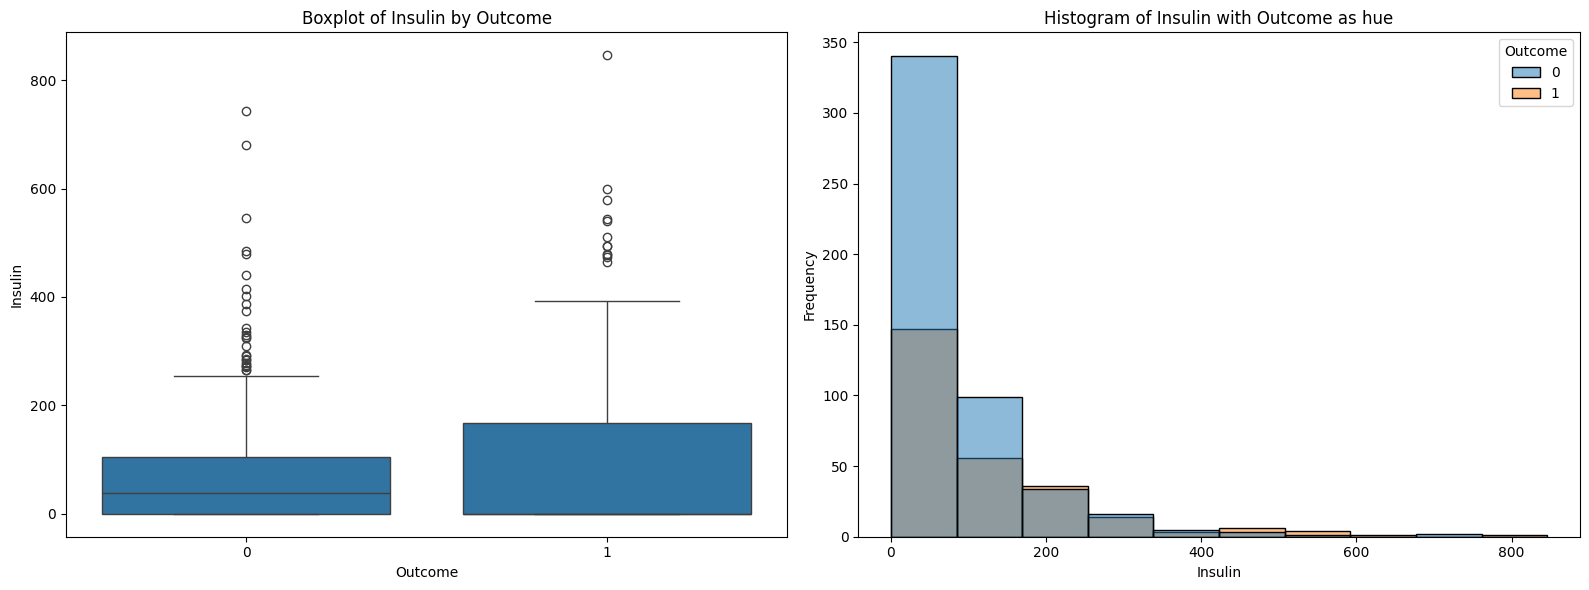

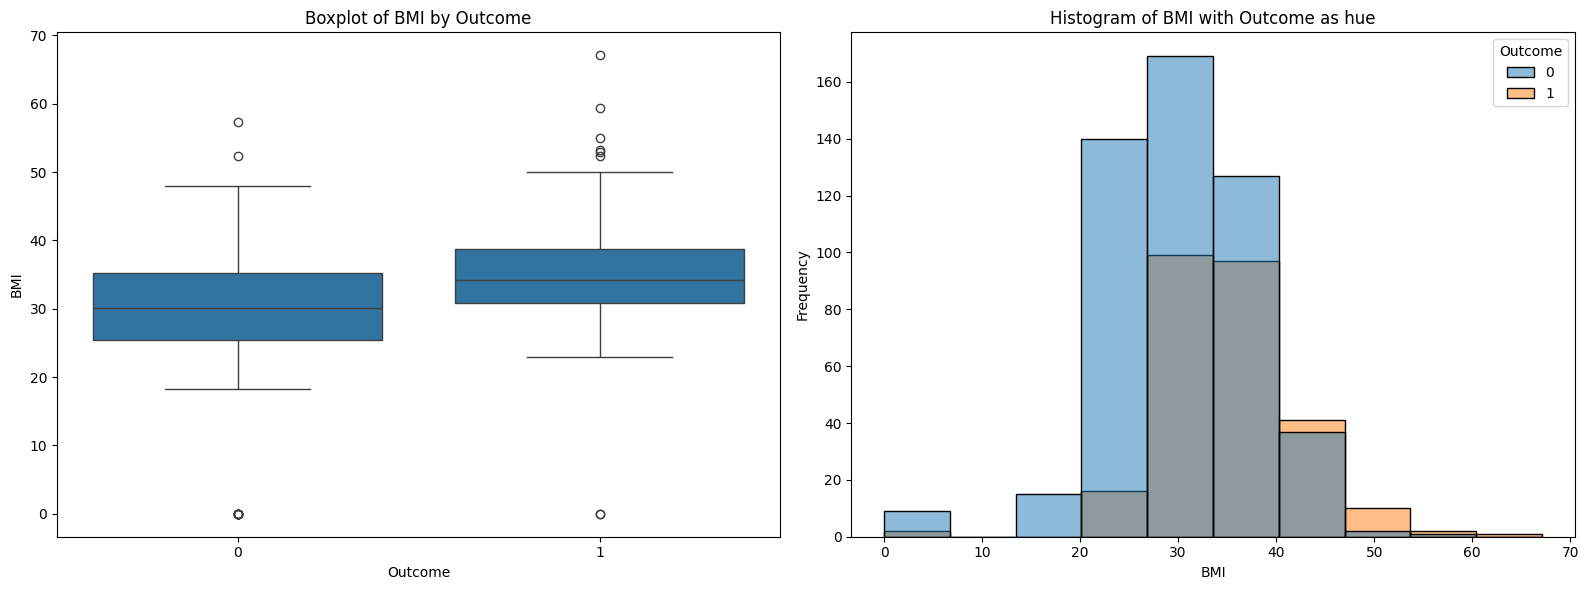

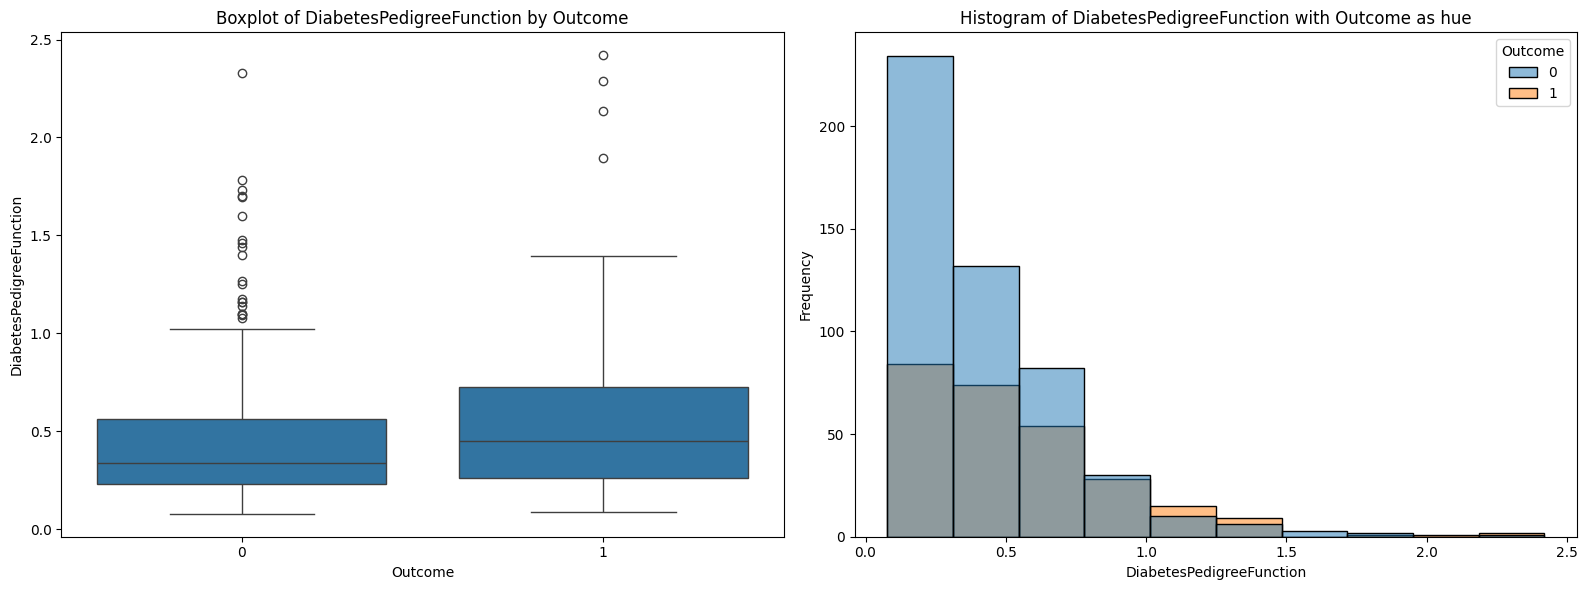

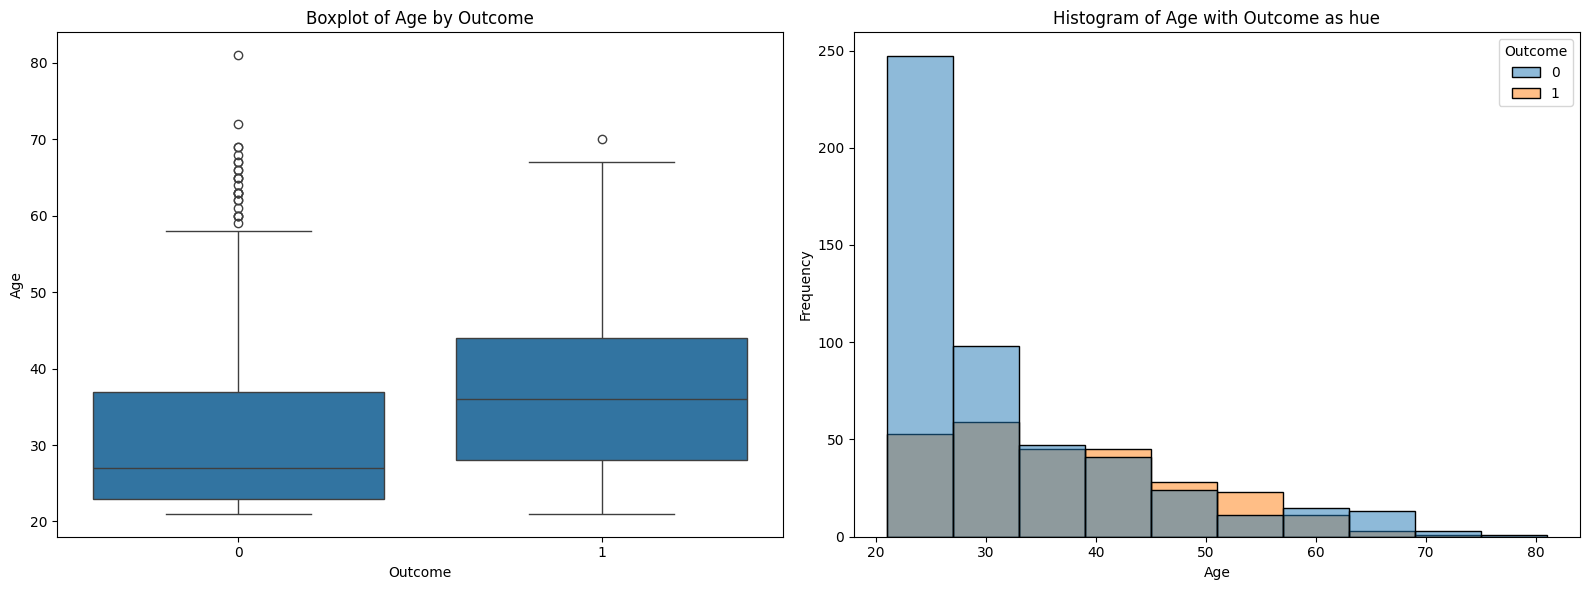

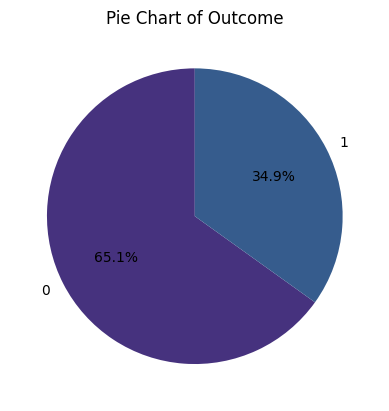

In [306]:
for column in df.columns:
    if column != "Outcome":
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Boxplot
        sns.boxplot(data=df, x="Outcome", y=column, ax=axes[0])
        axes[0].set_title(f'Boxplot of {column} by Outcome')
        axes[0].set_xlabel("Outcome")
        axes[0].set_ylabel(column)

        # Histogram
        sns.histplot(data=df, x=column, hue="Outcome", bins=10, kde=False, edgecolor="black", ax=axes[1])
        axes[1].set_title(f'Histogram of {column} with Outcome as hue')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    elif df[column].dtype.name == 'category':
        plt.figure()
        outcome_counts = df[column].value_counts()
        plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis"))
        plt.title(f'Pie Chart of {column}')
        plt.ylabel('')
        plt.show()

In [307]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


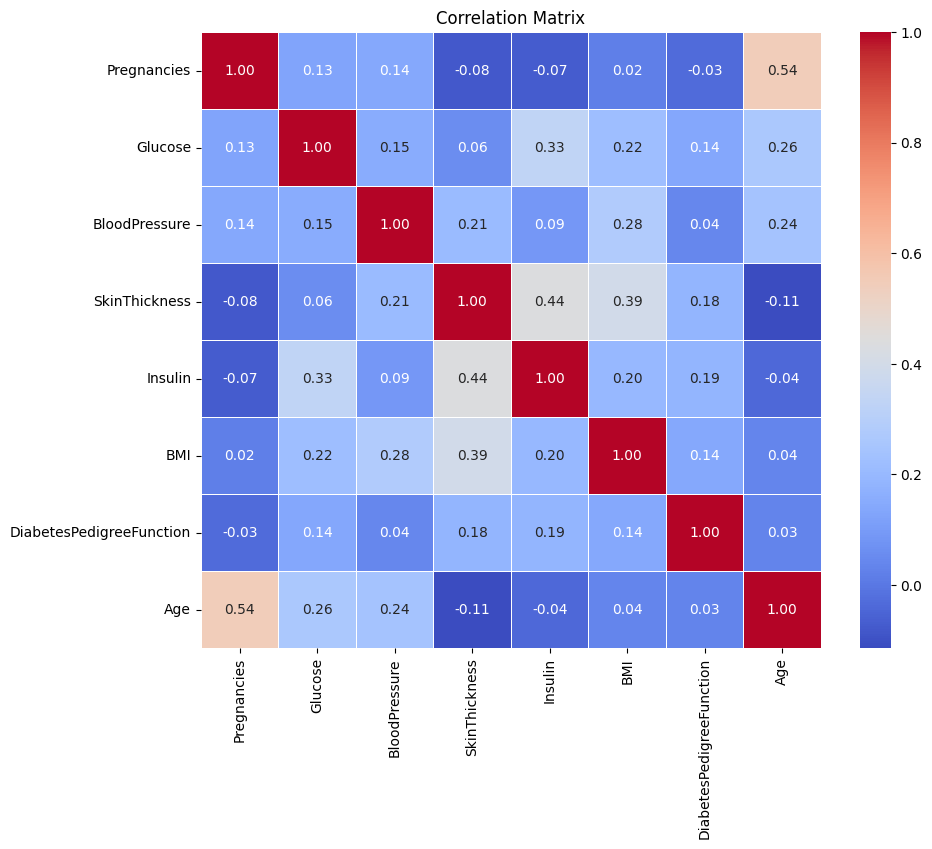

In [308]:
# Membuat plot korelasi
plt.figure(figsize=(10, 8))
correlation_matrix = df.drop(columns="Outcome").corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


## Data Preprocessing

In [309]:
# Normalisasi semua kolom kecuali Outcome menggunakan PowerTransformer
pt = PowerTransformer()
columns_to_normalize = df.select_dtypes(include=['int64', 'float64']).columns
columns_to_normalize = columns_to_normalize.drop("Outcome", errors='ignore')

df[columns_to_normalize] = pt.fit_transform(df[columns_to_normalize])

In [310]:
# Identifikasi dan penanganan outlier menggunakan IQR
for column in df.select_dtypes(include=["int64", "float64"]).columns:
    if column != "Outcome":
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Menandai dan menangani outlier
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

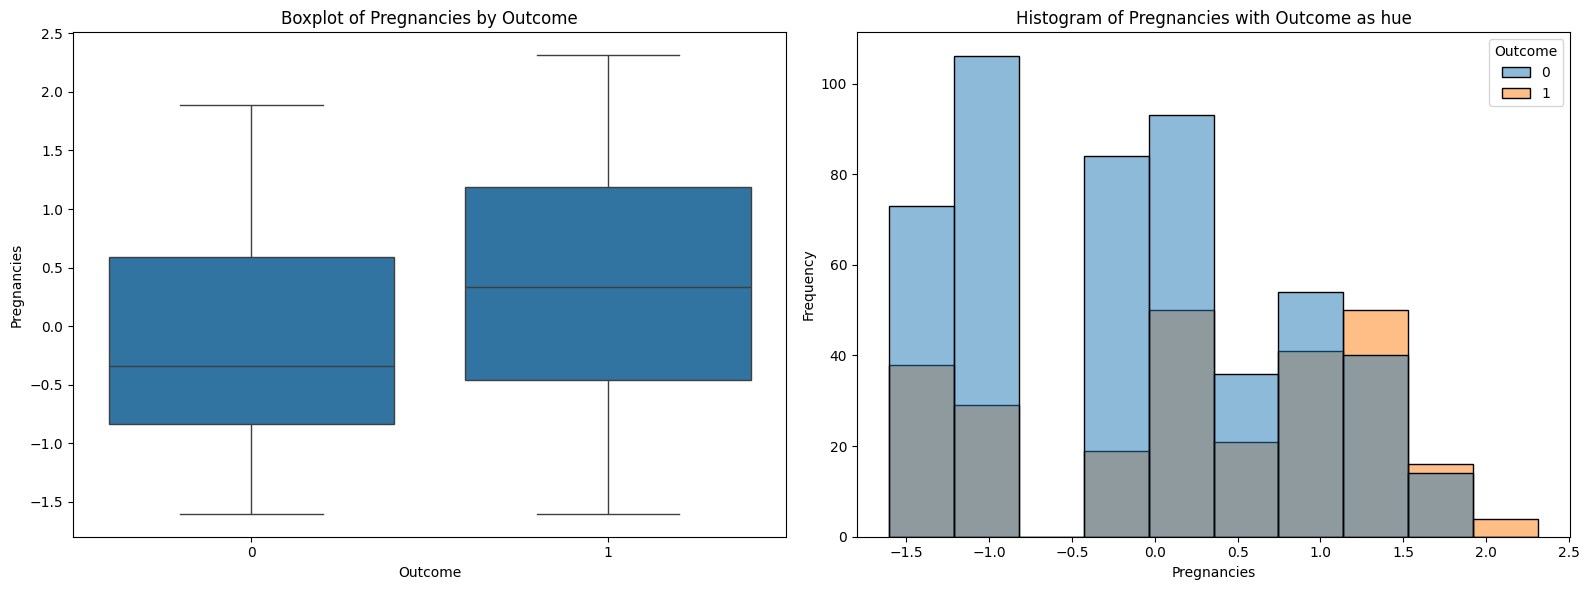

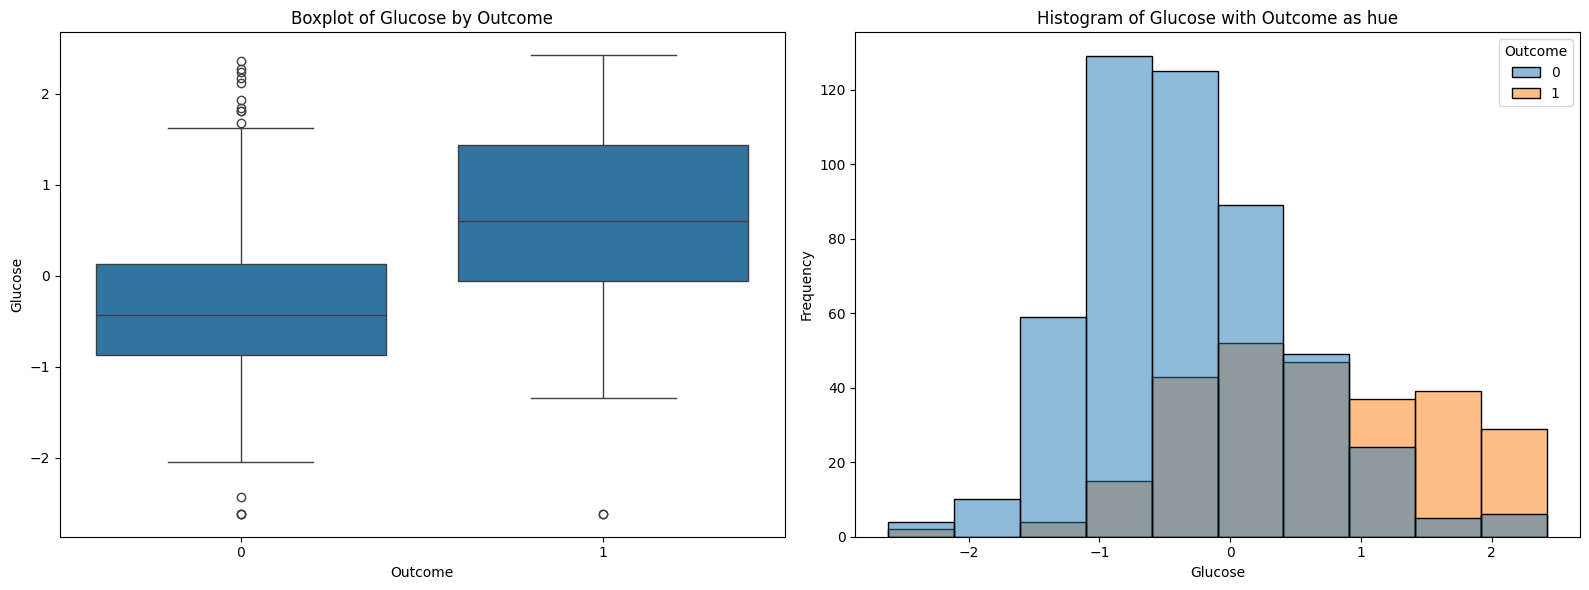

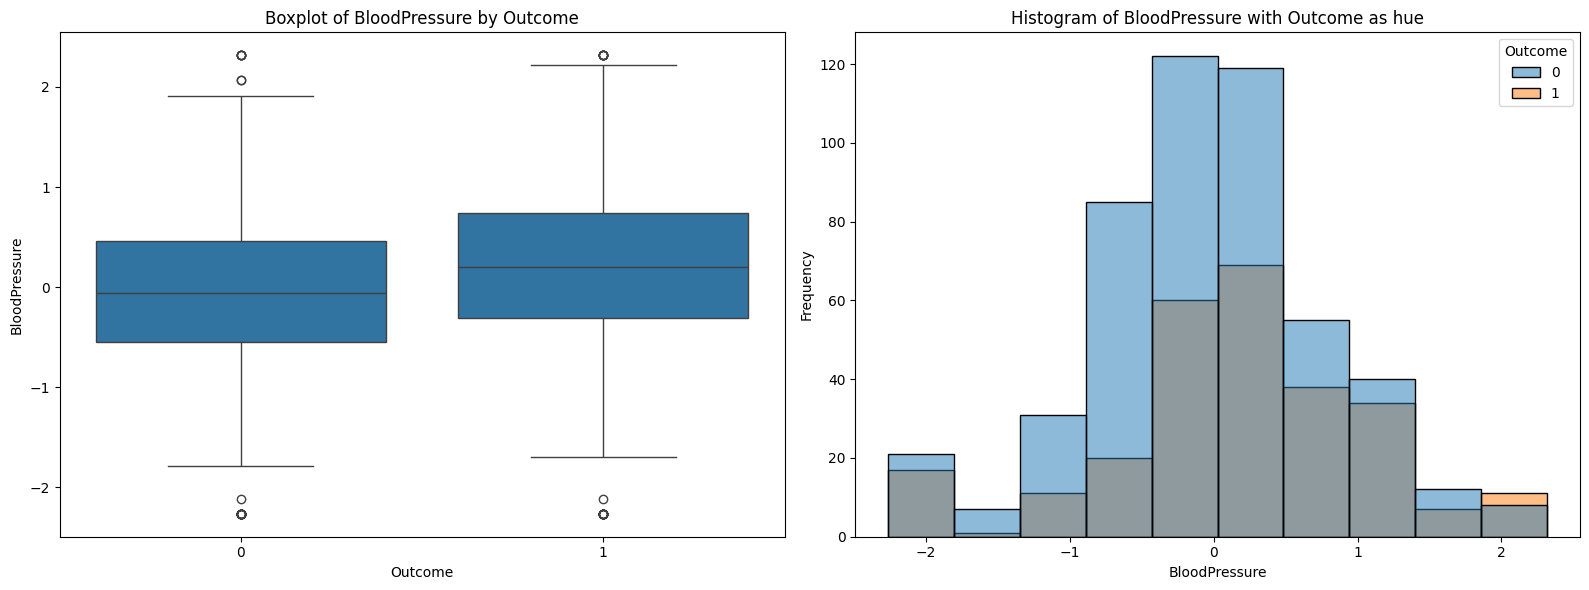

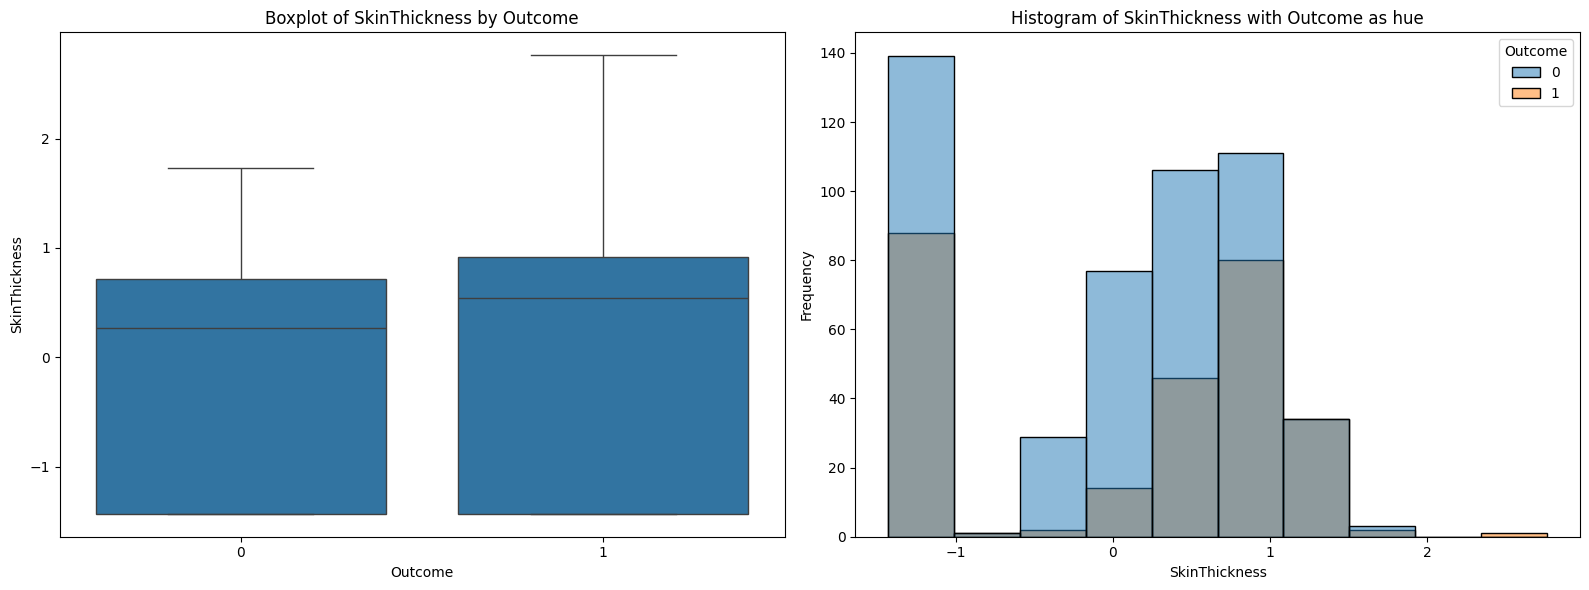

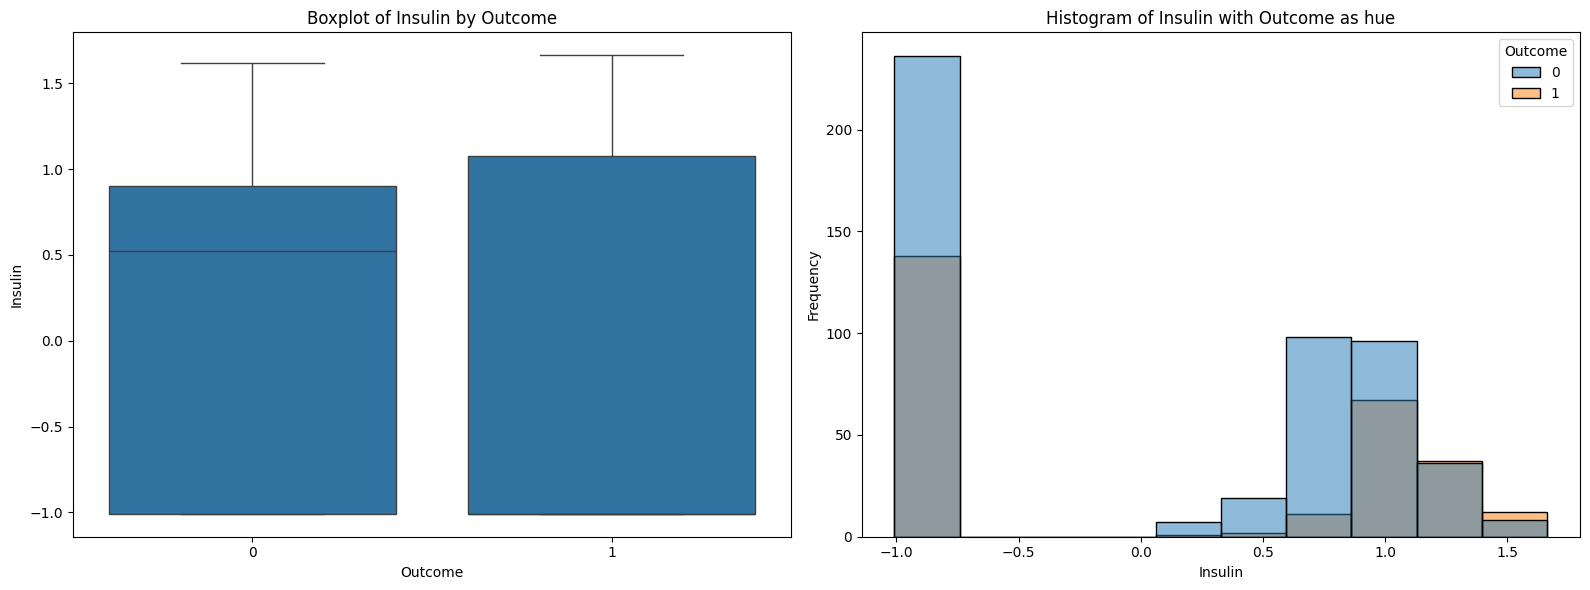

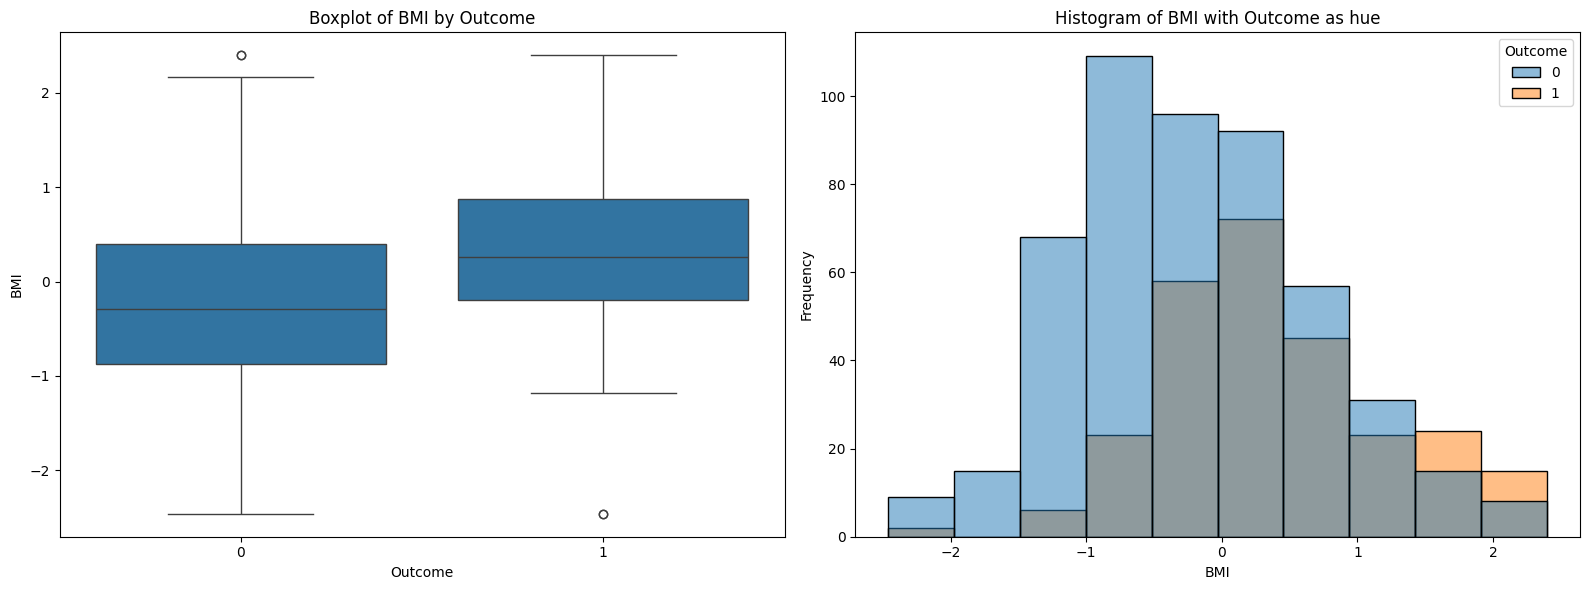

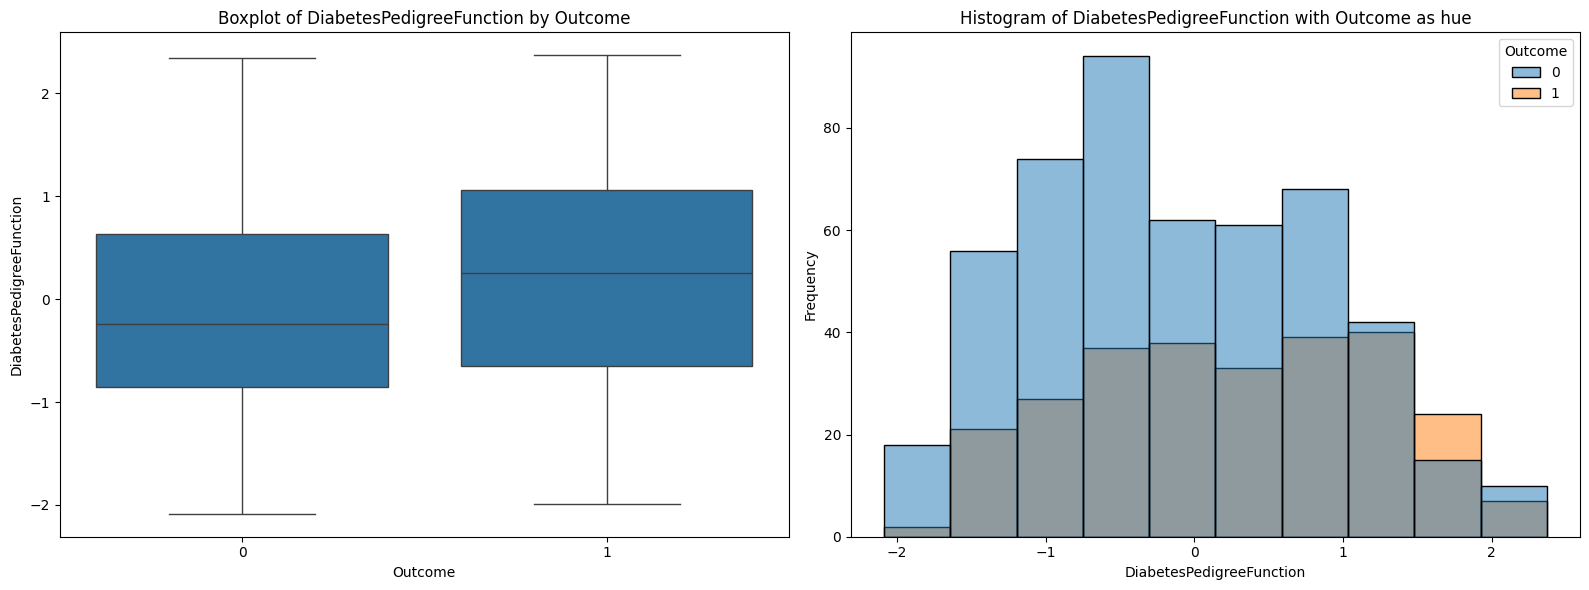

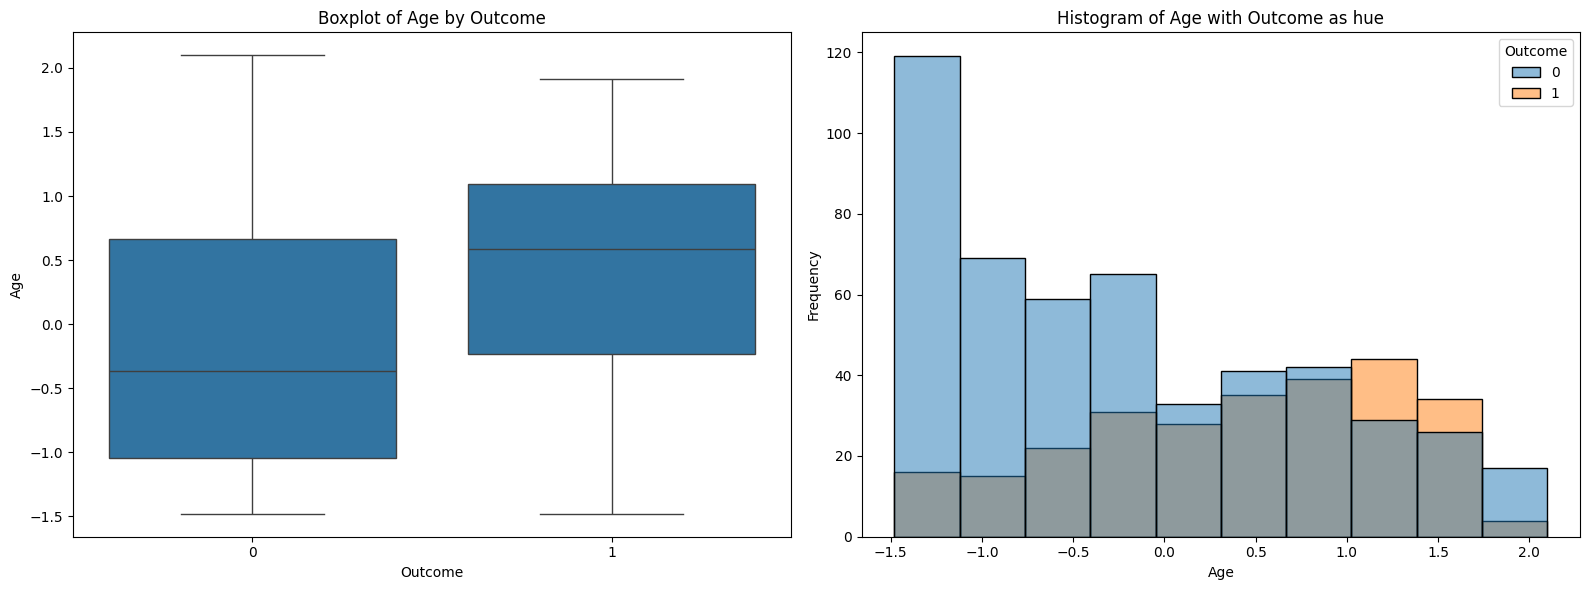

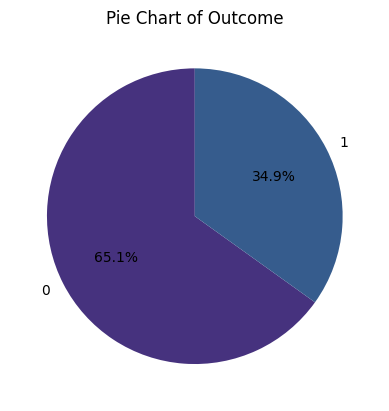

In [311]:
for column in df.columns:
    if column != "Outcome" and column in columns_to_normalize:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Boxplot
        sns.boxplot(data=df, x="Outcome", y=column, ax=axes[0])
        axes[0].set_title(f'Boxplot of {column} by Outcome')
        axes[0].set_xlabel("Outcome")
        axes[0].set_ylabel(column)

        # Histogram
        sns.histplot(data=df, x=column, hue="Outcome", bins=10, kde=False, edgecolor="black", ax=axes[1])
        axes[1].set_title(f'Histogram of {column} with Outcome as hue')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    elif df[column].dtype.name == 'category':
        plt.figure()
        outcome_counts = df[column].value_counts()
        plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis"))
        plt.title(f'Pie Chart of {column}')
        plt.ylabel('')
        plt.show()

## Training

In [312]:
X = df.drop(columns="Outcome")
y = df["Outcome"].cat.codes  # Mengonversi kategori ke bentuk numerik
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
pca = PCA(n_components=6)
X_resampled_pca = pca.fit_transform(X_resampled)
# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X_resampled_pca, y_resampled, test_size=0.2, random_state=42)

/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [313]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=kfold, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [314]:
# Evaluasi model
y_pred = clf.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", clf.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.2f}")


Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Confusion Matrix:
 [[76 23]
 [24 77]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.76        99
           1       0.77      0.76      0.77       101

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.77       200

Accuracy: 0.77


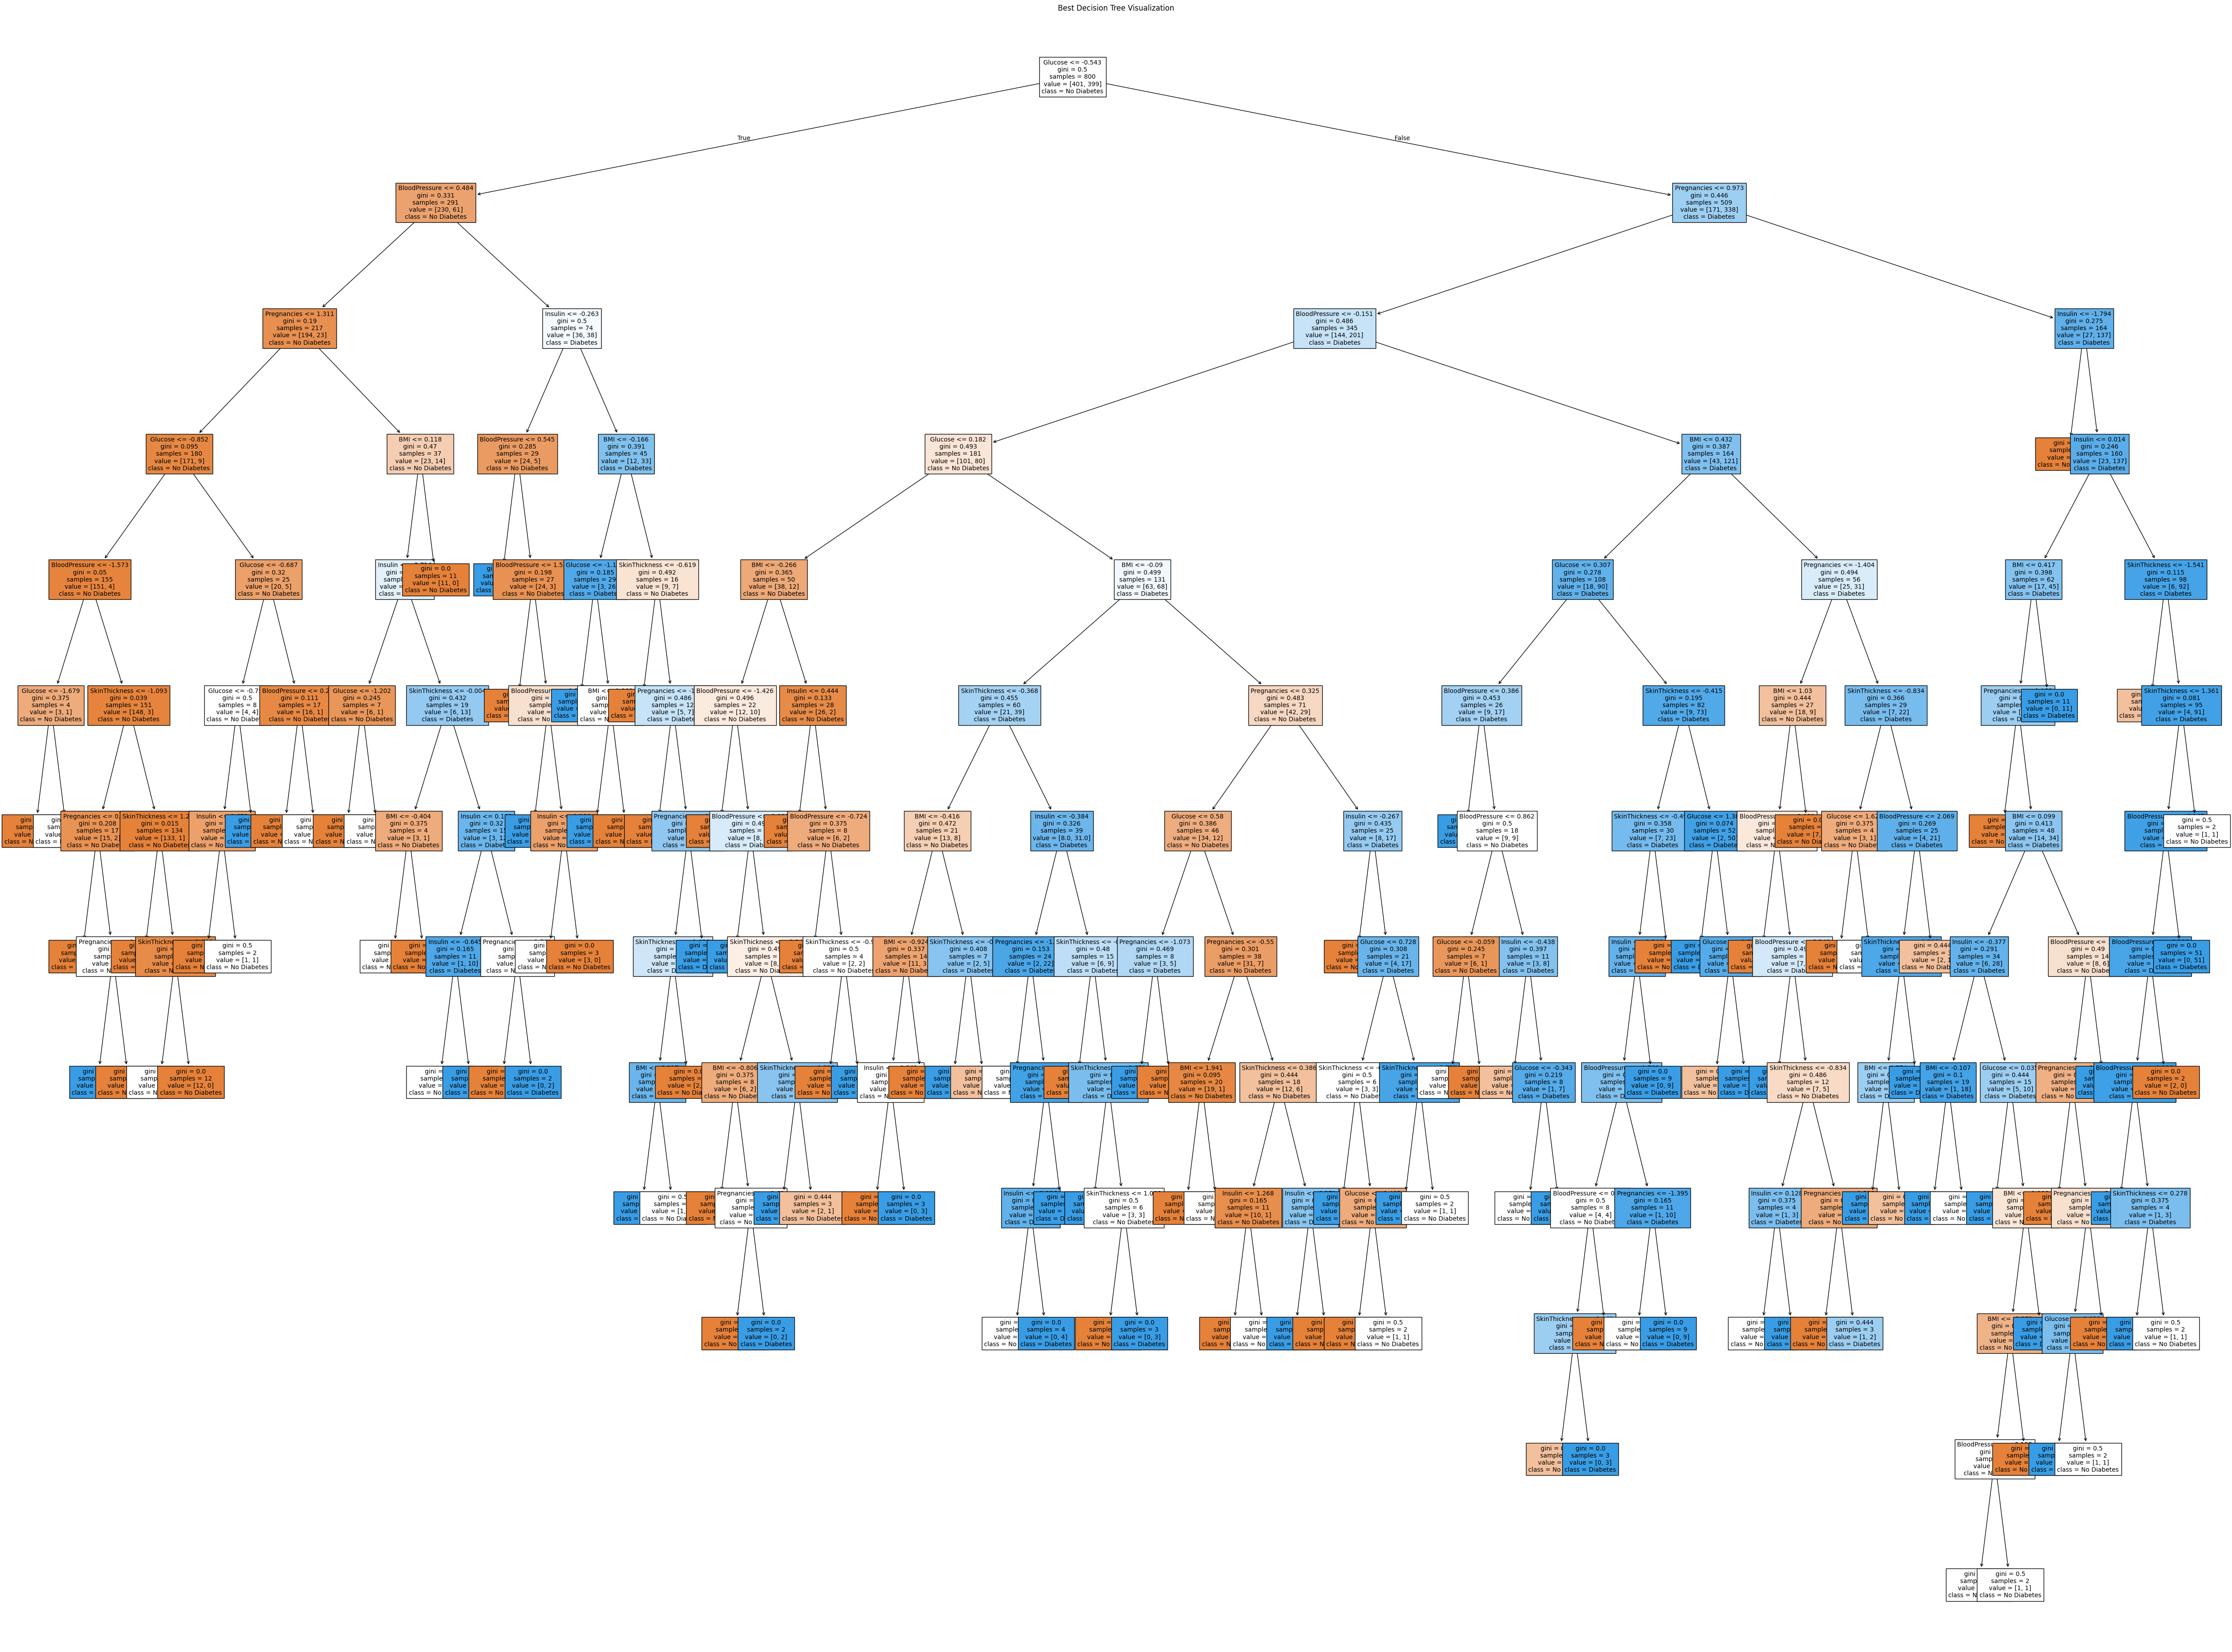

In [315]:
# Visualisasi Decision Tree
plt.figure(figsize=(64, 48))  # Memperbesar ukuran gambar untuk keterbacaan
plot_tree(clf.best_estimator_, feature_names=X.columns, class_names=["No Diabetes", "Diabetes"], filled=True, fontsize=10)
plt.title("Best Decision Tree Visualization")
plt.show()